# Building a Model

## Building a model component by component

### Model, Reactions and Metabolites 

*(Adapted from https://cobrapy.readthedocs.io/en/latest/building_model.html)*

This simple example demonstrates how to create a model, create a reaction, and then add the reaction to the model.

We’ll use the ‘3OAS140’ reaction from the *E.coli* iJO1366 model:

    1.0 malACP_c + 1.0 h_c + 1.0 ddcaACP_c → 1.0 co2_c + 1.0 ACP_c + 1.0 3omrsACP_c

### First, create the model.

In [1]:
from cobra import Model, Reaction, Metabolite

model = Model('example_model')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-10


Looking at the new models content, it should be empty with no reactions, metabolites, genes or objective function.

In [2]:
model

Name,example_model
Memory address,0x01c7a8a8a850
Number of metabolites,0
Number of reactions,0
Number of groups,0
Objective expression,0
Compartments,


### Creating a reaction

Create a reaction from the info in the BIGG database at http://bigg.ucsd.edu/models/iJO1366/reactions/3OAS140

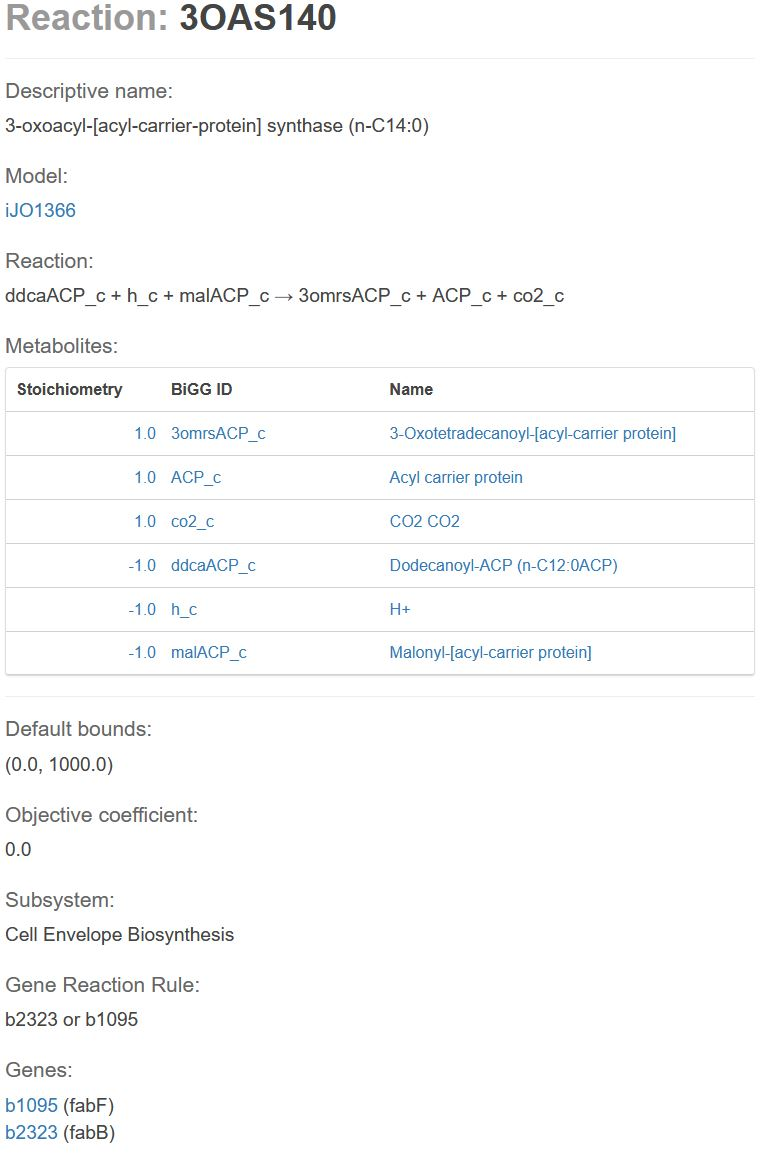


In [3]:
reaction = Reaction('R_3OAS140')
reaction.name = '3 oxoacyl acyl carrier protein synthase n C140'
reaction.subsystem = 'Cell Envelope Biosynthesis'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

### Creating the metabolites required by the reaction

It is now necessary to create the metabolites associated with the reaction. When using an existing model, you could use Model.get_by_id to get the appropriate Metabolite objects instead.

In [4]:
ACP_c = Metabolite(
    'ACP_c',
    formula='C11H21N2O7PRS',
    name='acyl-carrier-protein',
    compartment='c')
omrsACP_c = Metabolite(
    'M3omrsACP_c',
    formula='C25H45N2O9PRS',
    name='3-Oxotetradecanoyl-acyl-carrier-protein',
    compartment='c')
co2_c = Metabolite('co2_c', formula='CO2', name='CO2', compartment='c')
malACP_c = Metabolite(
    'malACP_c',
    formula='C14H22N2O10PRS',
    name='Malonyl-acyl-carrier-protein',
    compartment='c')
h_c = Metabolite('h_c', formula='H', name='H', compartment='c')
ddcaACP_c = Metabolite(
    'ddcaACP_c',
    formula='C23H43N2O8PRS',
    name='Dodecanoyl-ACP-n-C120ACP',
    compartment='c')

It is highly recommended that the ids for reactions, metabolites and genes are valid SBML identifiers (SId). SId is a data type derived from the basic XML typestring, but with restrictions about the characters permitted and the sequences in which those characters may appear.

    letter   ::=   ’a’..’z’,’A’..’Z’
    digit    ::=   ’0’..’9’
    idChar   ::=   letter | digit | ’_’
    SId      ::=   ( letter | ’_’ ) idChar*

The main limitation is that ids cannot start with numbers. Using SIds allows serialization to SBML. In addition features such as code completion and object access via the dot syntax will work in cobrapy.

### Adding metabolites to a reaction

Adding metabolites to a reaction uses a dictionary of the metabolites and their stoichiometric coefficients. A group of metabolites can be added all at once, or they can be added one at a time.

In [5]:
reaction.add_metabolites({
    malACP_c: -1.0,
    h_c: -1.0,
    ddcaACP_c: -1.0,
    co2_c: 1.0,
    ACP_c: 1.0,
    omrsACP_c: 1.0
})

reaction.reaction  # This gives a string representation of the reaction

'ddcaACP_c + h_c + malACP_c --> ACP_c + M3omrsACP_c + co2_c'

### Adding the gene reaction rule to the reaction

The gene_reaction_rule is a boolean representation of the gene requirements for this reaction to be active as described in Schellenberger et al 2011 Nature Protocols 6(9):1290-307. We will assign the gene reaction rule string, which will automatically create the corresponding gene objects.

In [6]:
reaction.gene_reaction_rule = '( b1095 or b2323 )'
reaction.genes

frozenset({<Gene b1095 at 0x1c7cbd30790>, <Gene b2323 at 0x1c7cbd30b20>})

At this point in time, the model is still empty

In [7]:
model

Name,example_model
Memory address,0x01c7a8a8a850
Number of metabolites,0
Number of reactions,0
Number of groups,0
Objective expression,0
Compartments,


### Adding the reaction to the model

Adding the reaction to the model, which will also add all associated metabolites and genes

In [8]:
model.add_reactions([reaction])
model

Name,example_model
Memory address,0x01c7a8a8a850
Number of metabolites,6
Number of reactions,1
Number of groups,0
Objective expression,0
Compartments,c


We can iterate through the model objects to observe the contents

In [9]:
# Iterate through the the objects in the model
print("Reactions")
print("---------")
for x in model.reactions:
    print("%s : %s" % (x.id, x.reaction))

print("")
print("Metabolites")
print("-----------")
for x in model.metabolites:
    print('%9s : %s' % (x.id, x.formula))

print("")
print("Genes")
print("-----")
for x in model.genes:
    associated_ids = (i.id for i in x.reactions)
    print("%s is associated with reactions: %s" %
          (x.id, "{" + ", ".join(associated_ids) + "}"))

Reactions
---------
R_3OAS140 : ddcaACP_c + h_c + malACP_c --> ACP_c + M3omrsACP_c + co2_c

Metabolites
-----------
 malACP_c : C14H22N2O10PRS
      h_c : H
ddcaACP_c : C23H43N2O8PRS
    co2_c : CO2
    ACP_c : C11H21N2O7PRS
M3omrsACP_c : C25H45N2O9PRS

Genes
-----
b1095 is associated with reactions: {R_3OAS140}
b2323 is associated with reactions: {R_3OAS140}


### Creating the model objective function

Last we need to define the objective function of the model in order to use flux balance analysis. Here, we just want this to be the maximization of the flux in the single reaction we added and we do this by assigning the reaction’s identifier to the objective property of the model.

In [10]:
model.objective = 'R_3OAS140'

The created objective is a symbolic algebraic expression and we can examine it by printing it

In [11]:
print(model.objective.expression)
print(model.objective.direction)

1.0*R_3OAS140 - 1.0*R_3OAS140_reverse_60acb
max


which shows that the solver will maximize the flux in the forward direction.

Again, looking at the model summary

In [12]:
model

Name,example_model
Memory address,0x01c7a8a8a850
Number of metabolites,6
Number of reactions,1
Number of groups,0
Objective expression,1.0*R_3OAS140 - 1.0*R_3OAS140_reverse_60acb
Compartments,c


In [13]:
solution = model.optimize()
solution

,fluxes,reduced_costs
R_3OAS140,0.0,0.0


To allow a flux to move through the reaction there needs to be a path to provide the input flux and path to accept the produced flux. This can be done with boundary reactions. A sink as the source and a demand as the flux recipient.

There are three input sources: ddcaACP_c, h_c, and malACP_c

In [14]:
print(model.add_boundary(model.metabolites.get_by_id("ddcaACP_c"), type="sink"))
print(model.add_boundary(model.metabolites.get_by_id("h_c"), type="sink"))
print(model.add_boundary(model.metabolites.get_by_id("malACP_c"), type="sink"))

SK_ddcaACP_c: ddcaACP_c <=> 
SK_h_c: h_c <=> 
SK_malACP_c: malACP_c <=> 


There are three product metabolites: ACP_c + M3omrsACP_c + co2_c. We will use a demand reaction to accept the flux.

In [15]:
print(model.add_boundary(model.metabolites.get_by_id("ACP_c"), type="demand"))
print(model.add_boundary(model.metabolites.get_by_id("M3omrsACP_c"), type="demand"))
print(model.add_boundary(model.metabolites.get_by_id("co2_c"), type="demand"))

DM_ACP_c: ACP_c --> 
DM_M3omrsACP_c: M3omrsACP_c --> 
DM_co2_c: co2_c --> 


An Escher map of this model is

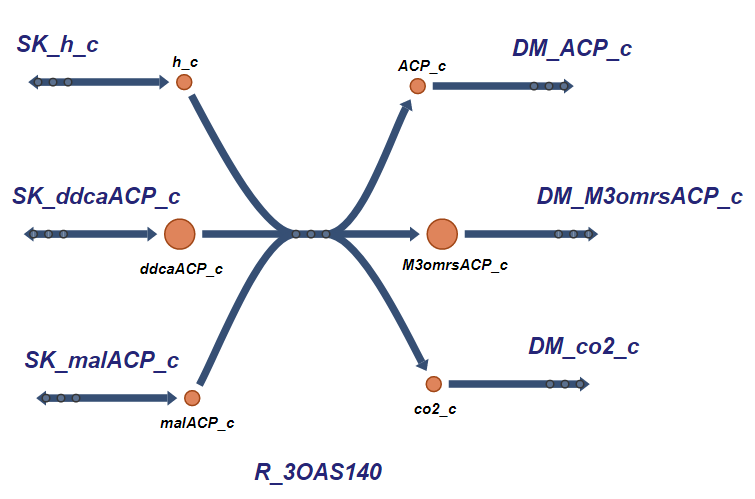

Setting the bounds on the primary product metabolite.

In [16]:
model.reactions.DM_M3omrsACP_c.bounds = 0,1
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ddcaACP_c,SK_ddcaACP_c,1,23,62.16%
h_c,SK_h_c,1,0,0.00%
malACP_c,SK_malACP_c,1,14,37.84%
Metabolite,Reaction,Flux,C-Number,C-Flux
ACP_c,DM_ACP_c,-1,11,29.73%
M3omrsACP_c,DM_M3omrsACP_c,-1,25,67.57%
co2_c,DM_co2_c,-1,1,2.70%


Note, there is flux flowing through the reaction.

Now let's look at the model summary to see the reactions included in the model. We should see both the sink and demand reactions included.

In [17]:
model

Name,example_model
Memory address,0x01c7a8a8a850
Number of metabolites,6
Number of reactions,7
Number of groups,0
Objective expression,1.0*R_3OAS140 - 1.0*R_3OAS140_reverse_60acb
Compartments,c


Note, there is flux flowing through the reaction.

### Saving the model in JSON format

In [18]:
import cobra
from cobra.io import save_json_model
cobra.io.save_json_model(model, "test.json")

## Adding a reaction from the BIGG database

Adding the HOXG reaction from Synechocystis sp. PCC 6803 (http://bigg.ucsd.edu/models/iSynCJ816/reactions/HOXG) reaction to the example model above. Begin by downloading the iSynCJ816 model.

In [19]:
from cameo import models
model_iSynCJ816 = models.bigg.iSynCJ816

The attributes of this reaction are

In [20]:
model_iSynCJ816.reactions.HOXG

Reaction identifier,HOXG
Name,Heme oxygenase 1
Memory address,0x01c7cf9e7520
Stoichiometry,5.0 h_c + 3.0 nadph_c + 3.0 o2_c + pheme_c --> biliverd_c + co_c + fe2_c + 3.0 h2o_c + 3.0 nadp_c 5.0 H+ + 3.0 Nicotinamide adenine dinucleotide phosphate - reduced + 3.0 O2 O2 + Protoheme C34H30FeN4O4 --> Biliverdin cytosol + Carbon monoxide + Fe2+ mitochondria + 3.0 H2O H2O + 3.0 Nicotinamide...
GPR,SGL_RS03350 or SGL_RS10385
Lower bound,0.0
Upper bound,999999.0


Adding the reaction to the model

In [21]:
model.add_reactions([model_iSynCJ816.reactions.HOXG])

Now looking at the attributes of the model

In [22]:
model

Name,example_model
Memory address,0x01c7a8a8a850
Number of metabolites,14
Number of reactions,8
Number of groups,0
Objective expression,1.0*R_3OAS140 - 1.0*R_3OAS140_reverse_60acb
Compartments,c


Note how easy this is compared to building a model from scratch!

In [23]:
model.reactions.HOXG

Reaction identifier,HOXG
Name,Heme oxygenase 1
Memory address,0x01c7cf9e7520
Stoichiometry,5.0 h_c + 3.0 nadph_c + 3.0 o2_c + pheme_c --> biliverd_c + co_c + fe2_c + 3.0 h2o_c + 3.0 nadp_c 5.0 H + 3.0 Nicotinamide adenine dinucleotide phosphate - reduced + 3.0 O2 O2 + Protoheme C34H30FeN4O4 --> Biliverdin cytosol + Carbon monoxide + Fe2+ mitochondria + 3.0 H2O H2O + 3.0 Nicotinamide...
GPR,SGL_RS03350 or SGL_RS10385
Lower bound,0.0
Upper bound,999999.0
